In [1]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2023-02-01 15:39:12.961544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 15:39:13.867026: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/riga/anaconda3/envs/tf-gpu/lib/
2023-02-01 15:39:13.867096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/riga/anaconda3/envs/tf-gpu/lib/
2023-02-01 15:39:13.867106: W tensorflow/compiler/tf2t

2.11.0


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
image_dir = "./resized_train"
caption_pred_file = "caption_prediction_train.csv"
concept_pred_file = "concept_prediction_train.csv"
concept_file = "concepts.csv"

In [4]:
concepts = pd.read_csv(concept_file, sep='\t')
concepts = concepts.set_index('concept')['concept_name'].to_dict()

captions = pd.read_csv(caption_pred_file, sep='\t')
captions = captions.set_index('ID')['caption'].to_dict()

In [5]:
# Define a list of characters to strip from input text
strip_chars = string.punctuation + "¿"

# Remove "[" and "]" from the list of stripped characters
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [6]:
result = ""
for i in captions.values():
    result += " " + i
result = custom_standardization(result)
result = bytes.decode(result.numpy())
print("Vocab size:")
print(len(set(result.split())))

longest = max(captions.values(), key=len)
longest = custom_standardization(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
print("Longest sequence:")
print(len(longest))

2023-02-01 15:39:15.907693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:39:15.912752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:39:15.913028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:39:15.913610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Vocab size:
35489
Longest sequence:
391


In [7]:
def load_data(limit=0):
    images = []
    _max = 0
    
    files = [filename for filename in os.listdir(image_dir)]
    if limit != 0:
        files = random.sample(files, limit)
        
    for filename in files:
        name = os.path.splitext(filename)[0]
        if name not in captions:
            continue

        image_path = os.path.join(image_dir, name + ".jpg")
        image = cv2.imread(image_path)

        # Preprocess images
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 
        
        # Preprocess texts
        text = captions[name]
        text = "[SOS] " + text + " [EOS]"
        text = text_vectorization(captions[name])
        
        images.append((image, text))
            
    return images

def load_dataset(limit=0, test=0.2, val=0.0):
    image_pairs = load_data(limit)
    
    random.shuffle(image_pairs)
    num_test_samples = int(test * len(image_pairs))
    num_val_samples = int(val * len(image_pairs))
    test_pairs = image_pairs[:num_test_samples]
    val_pairs = image_pairs[num_test_samples : num_test_samples + num_val_samples]
    train_pairs = image_pairs[num_test_samples + num_val_samples :]
    
    return train_pairs, val_pairs, test_pairs

def visualize_dataset(dataset, nums=5):
    for n, (i, t) in enumerate(random.sample(dataset, nums)):
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, n + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])

In [8]:
vocab_size = 35491
sequence_length = 393

text_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
)

train_captions = [v for v in captions.values()]
text_vectorization.adapt(train_captions)

In [9]:
ds_train, ds_val, ds_test = load_dataset(100)

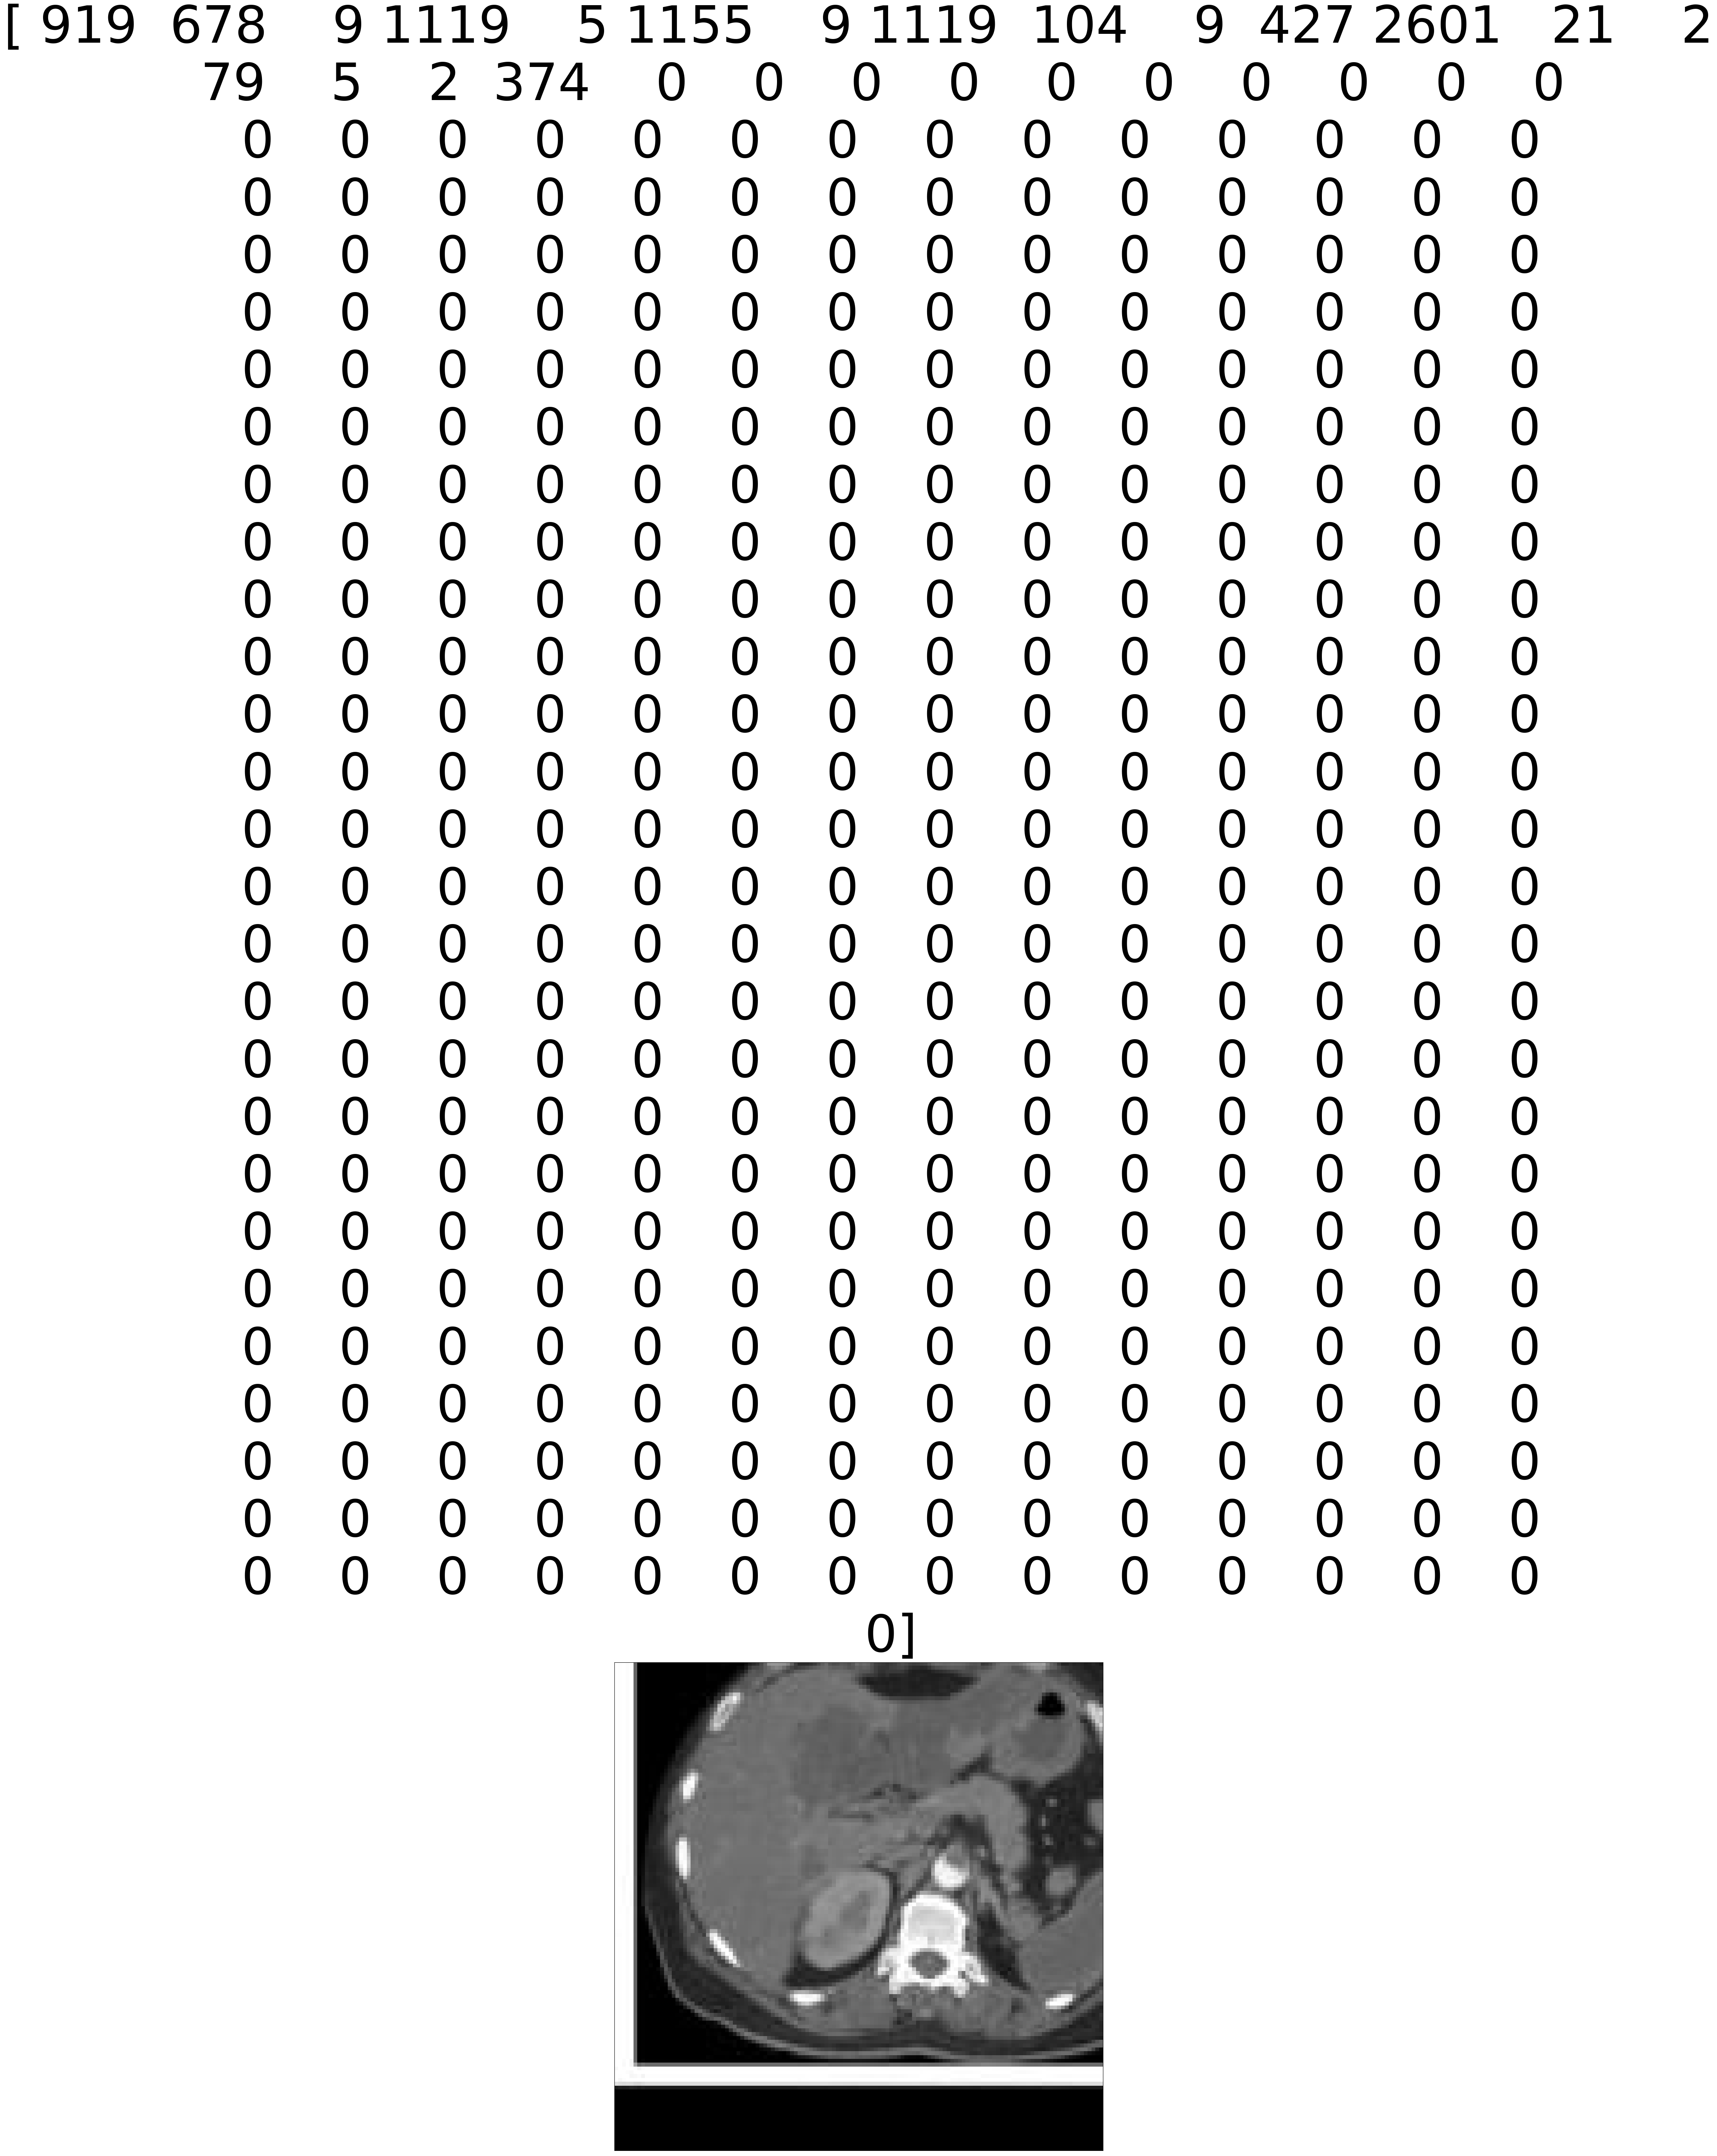

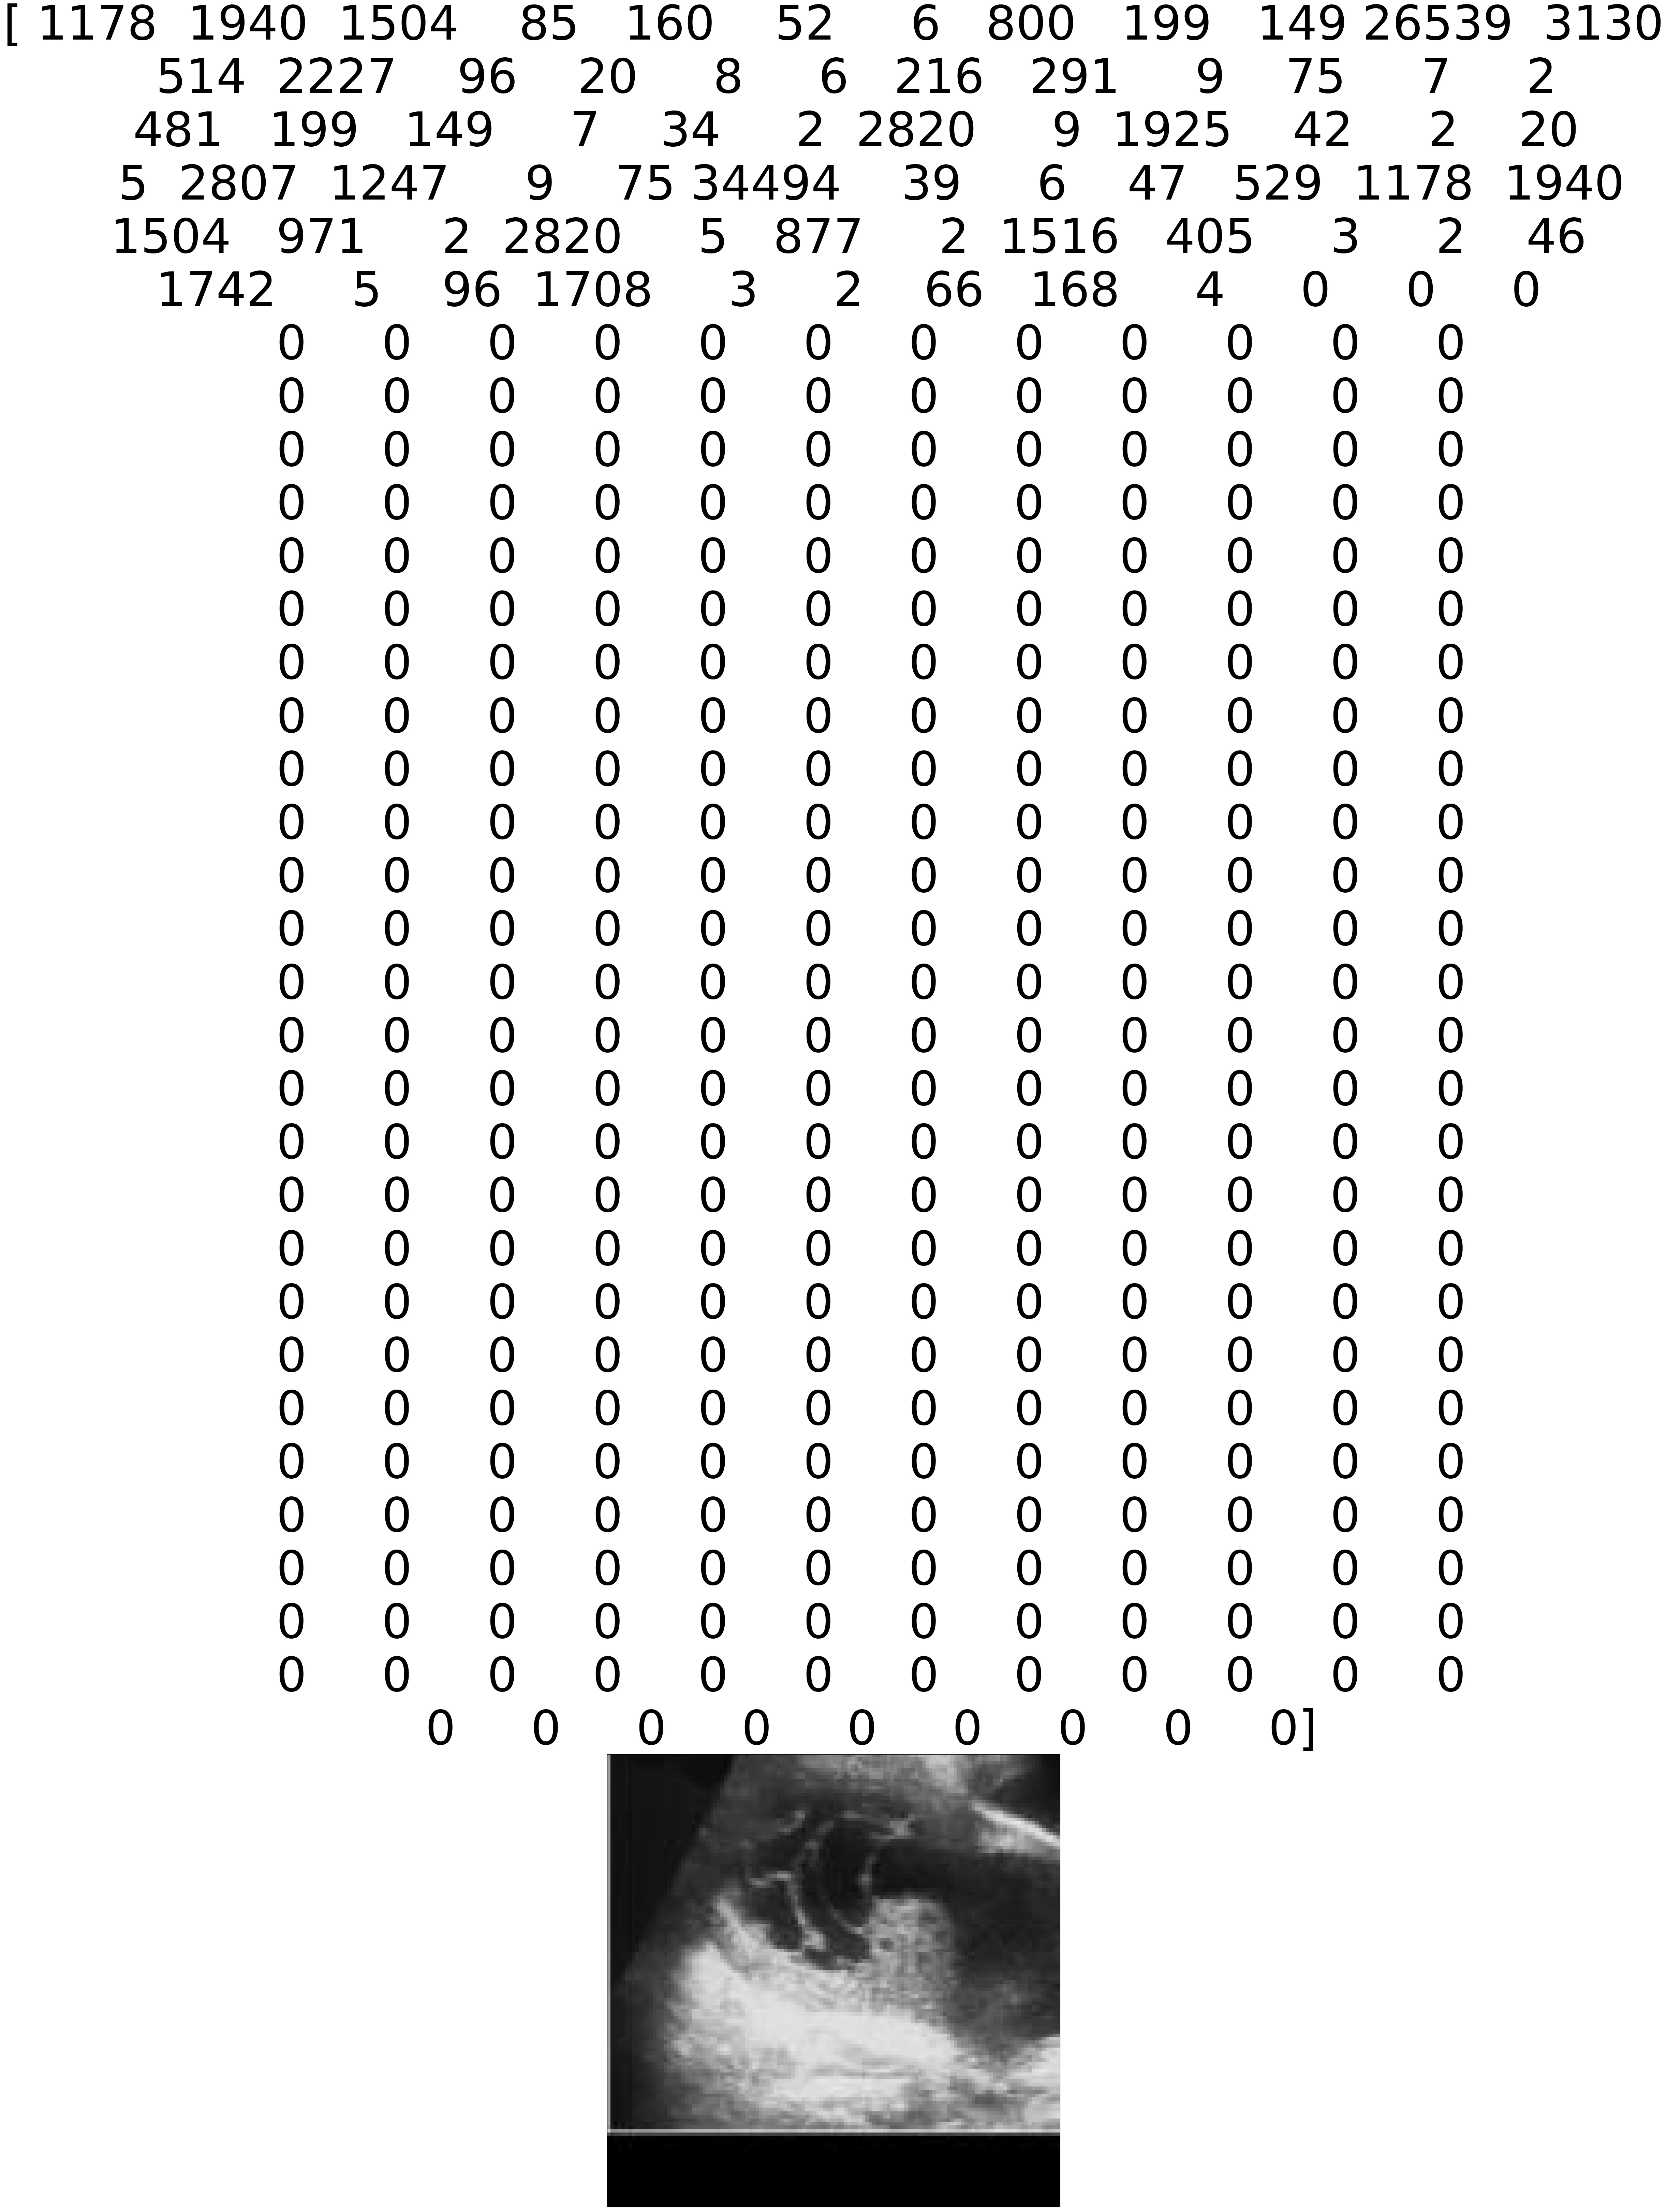

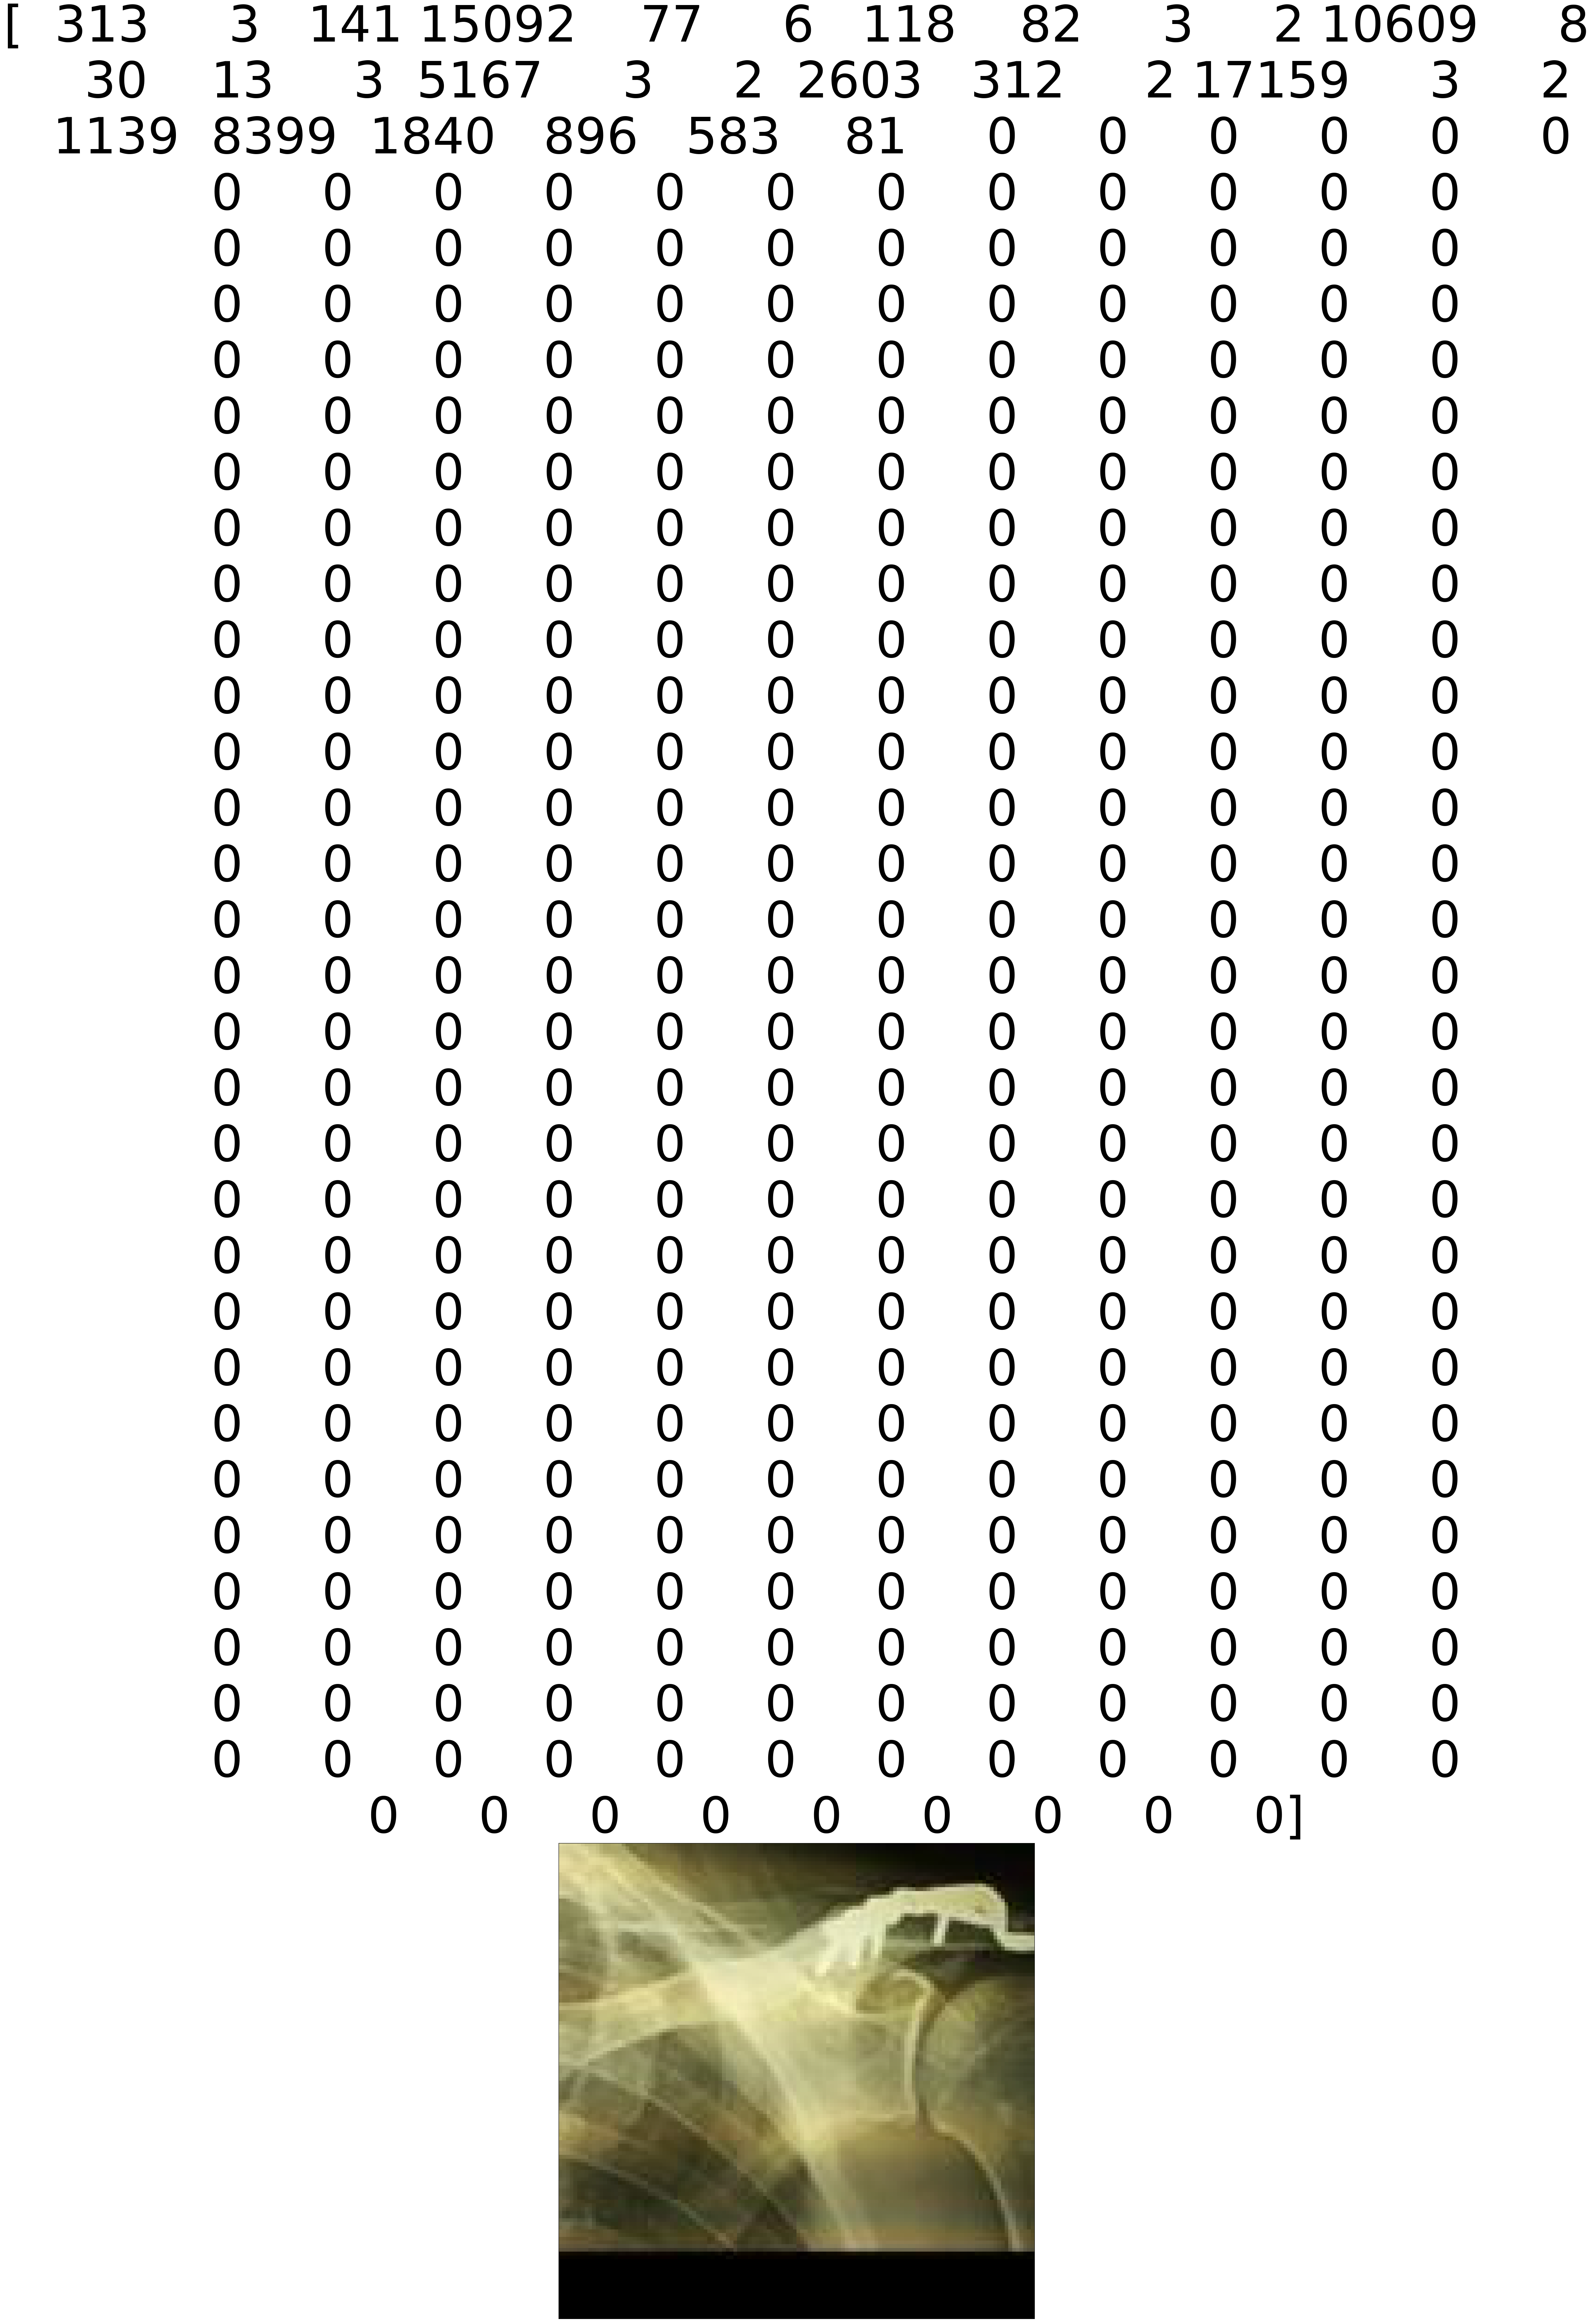

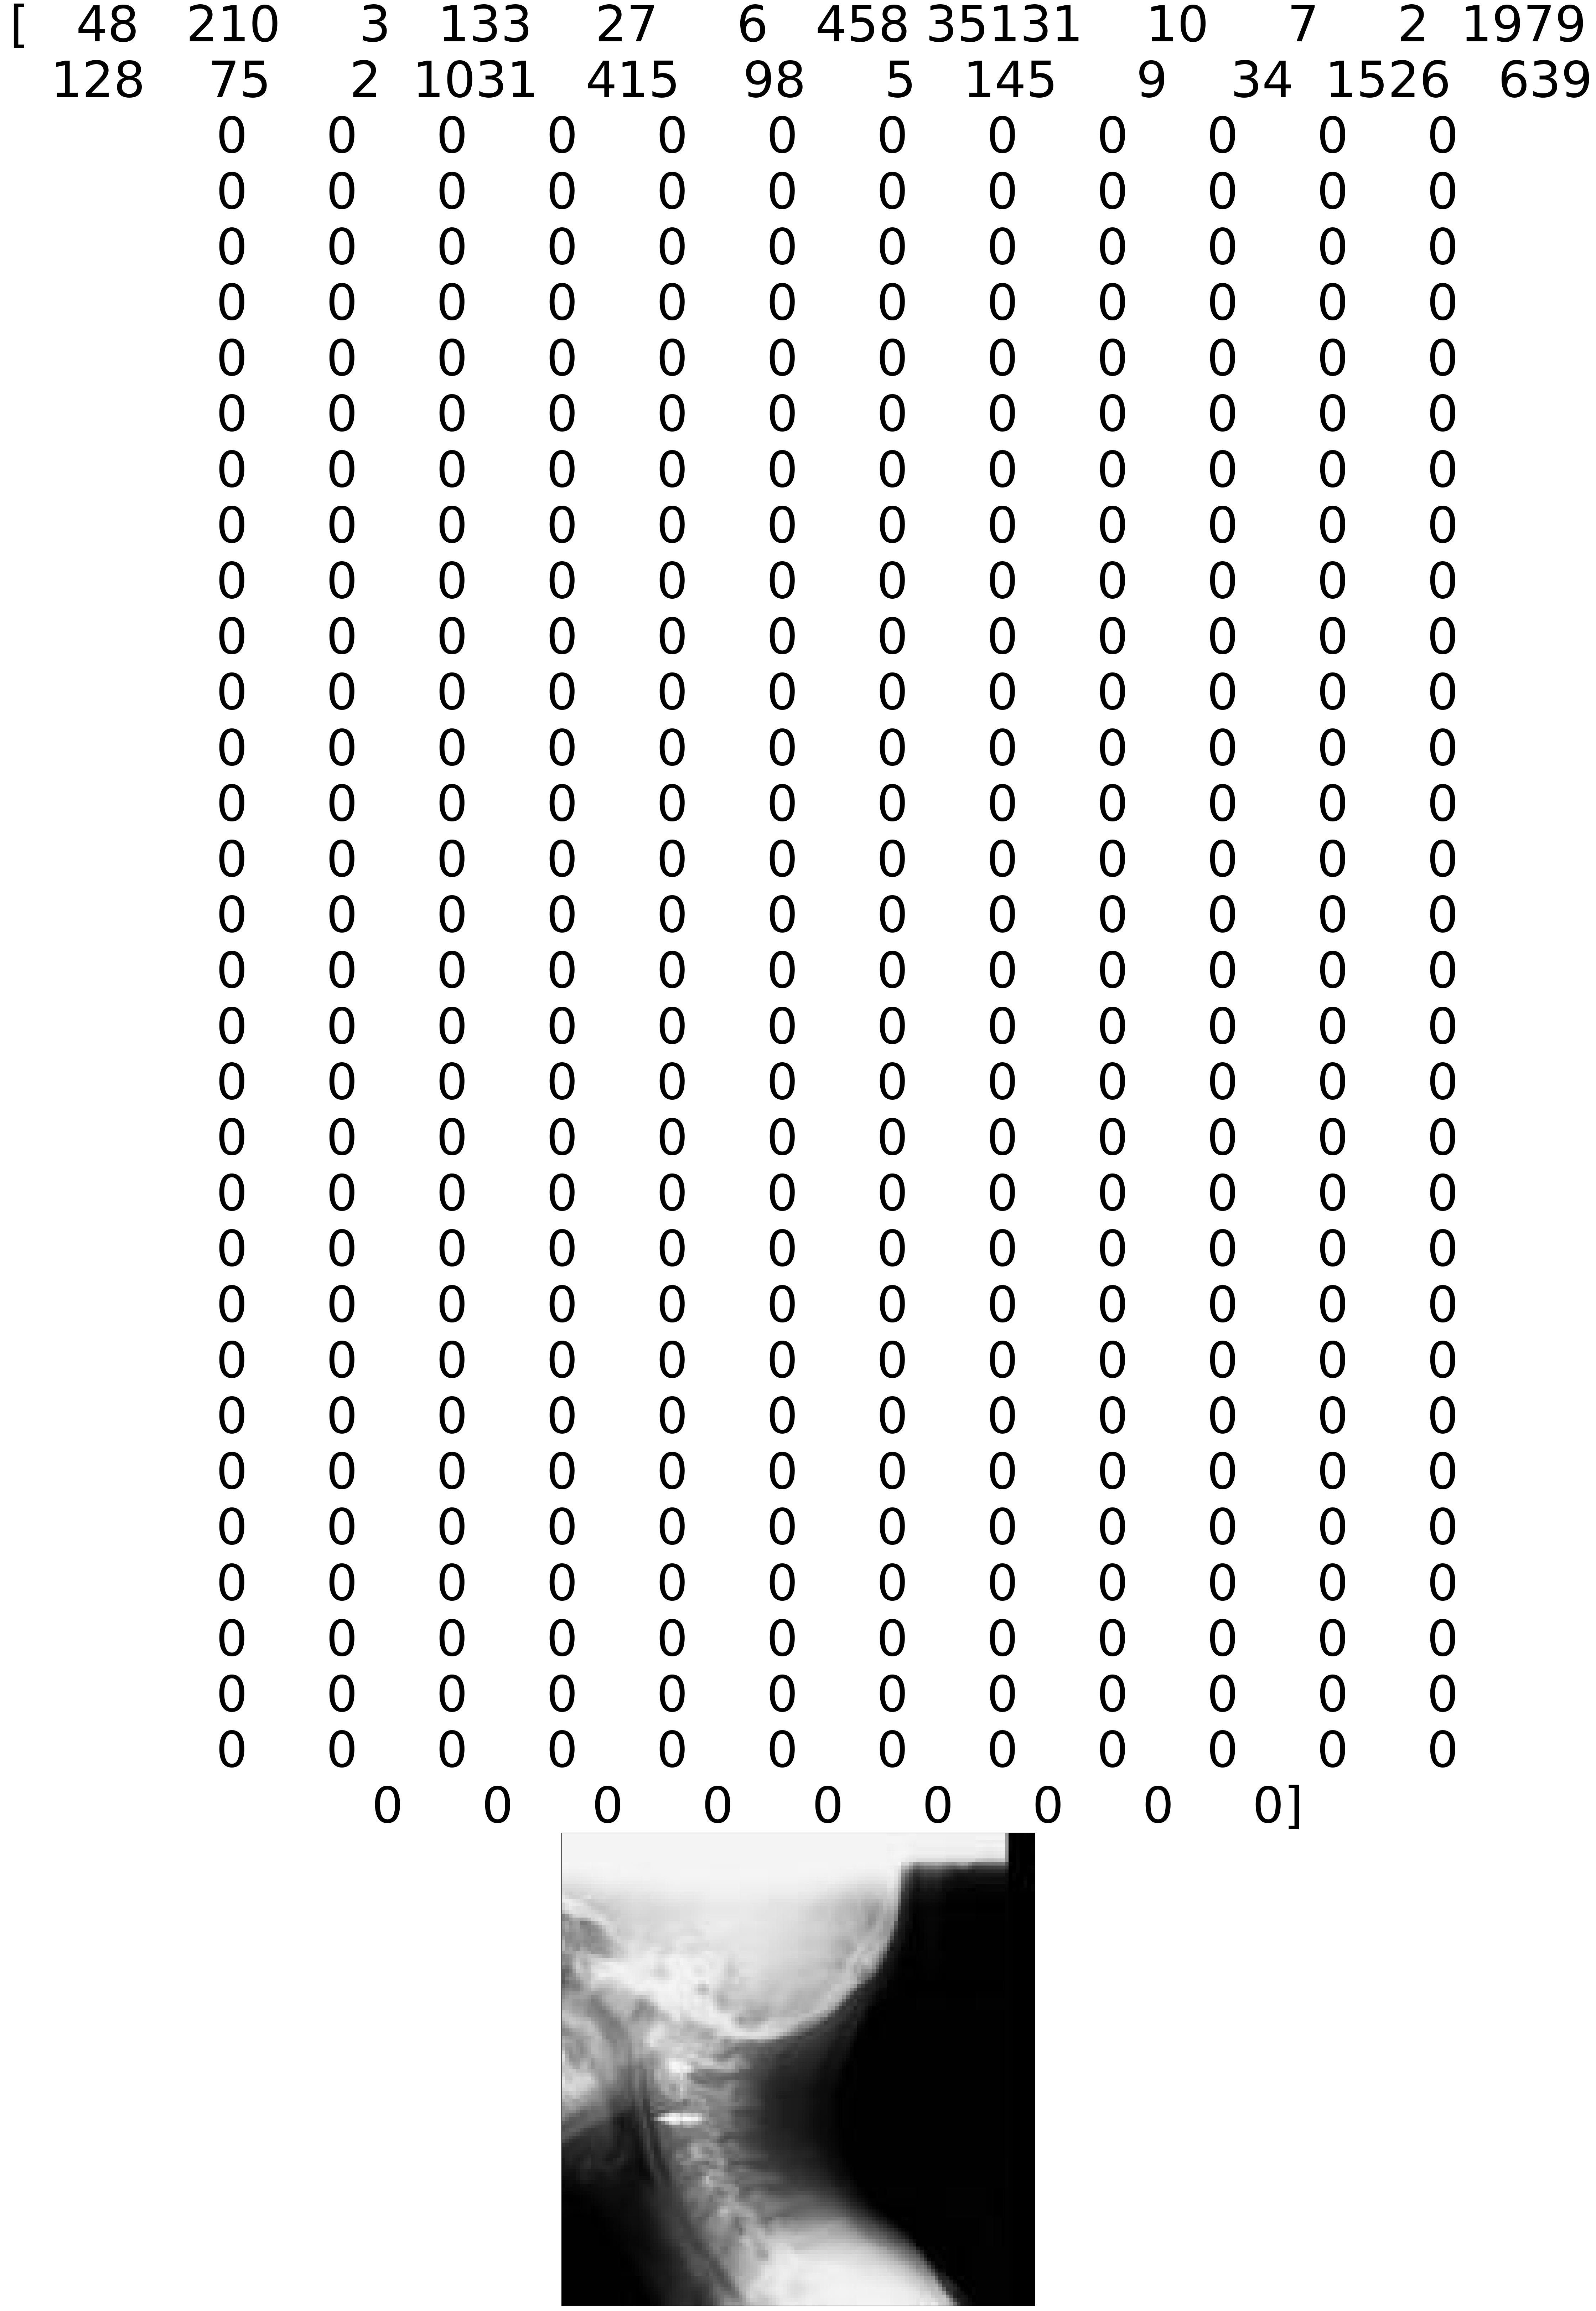

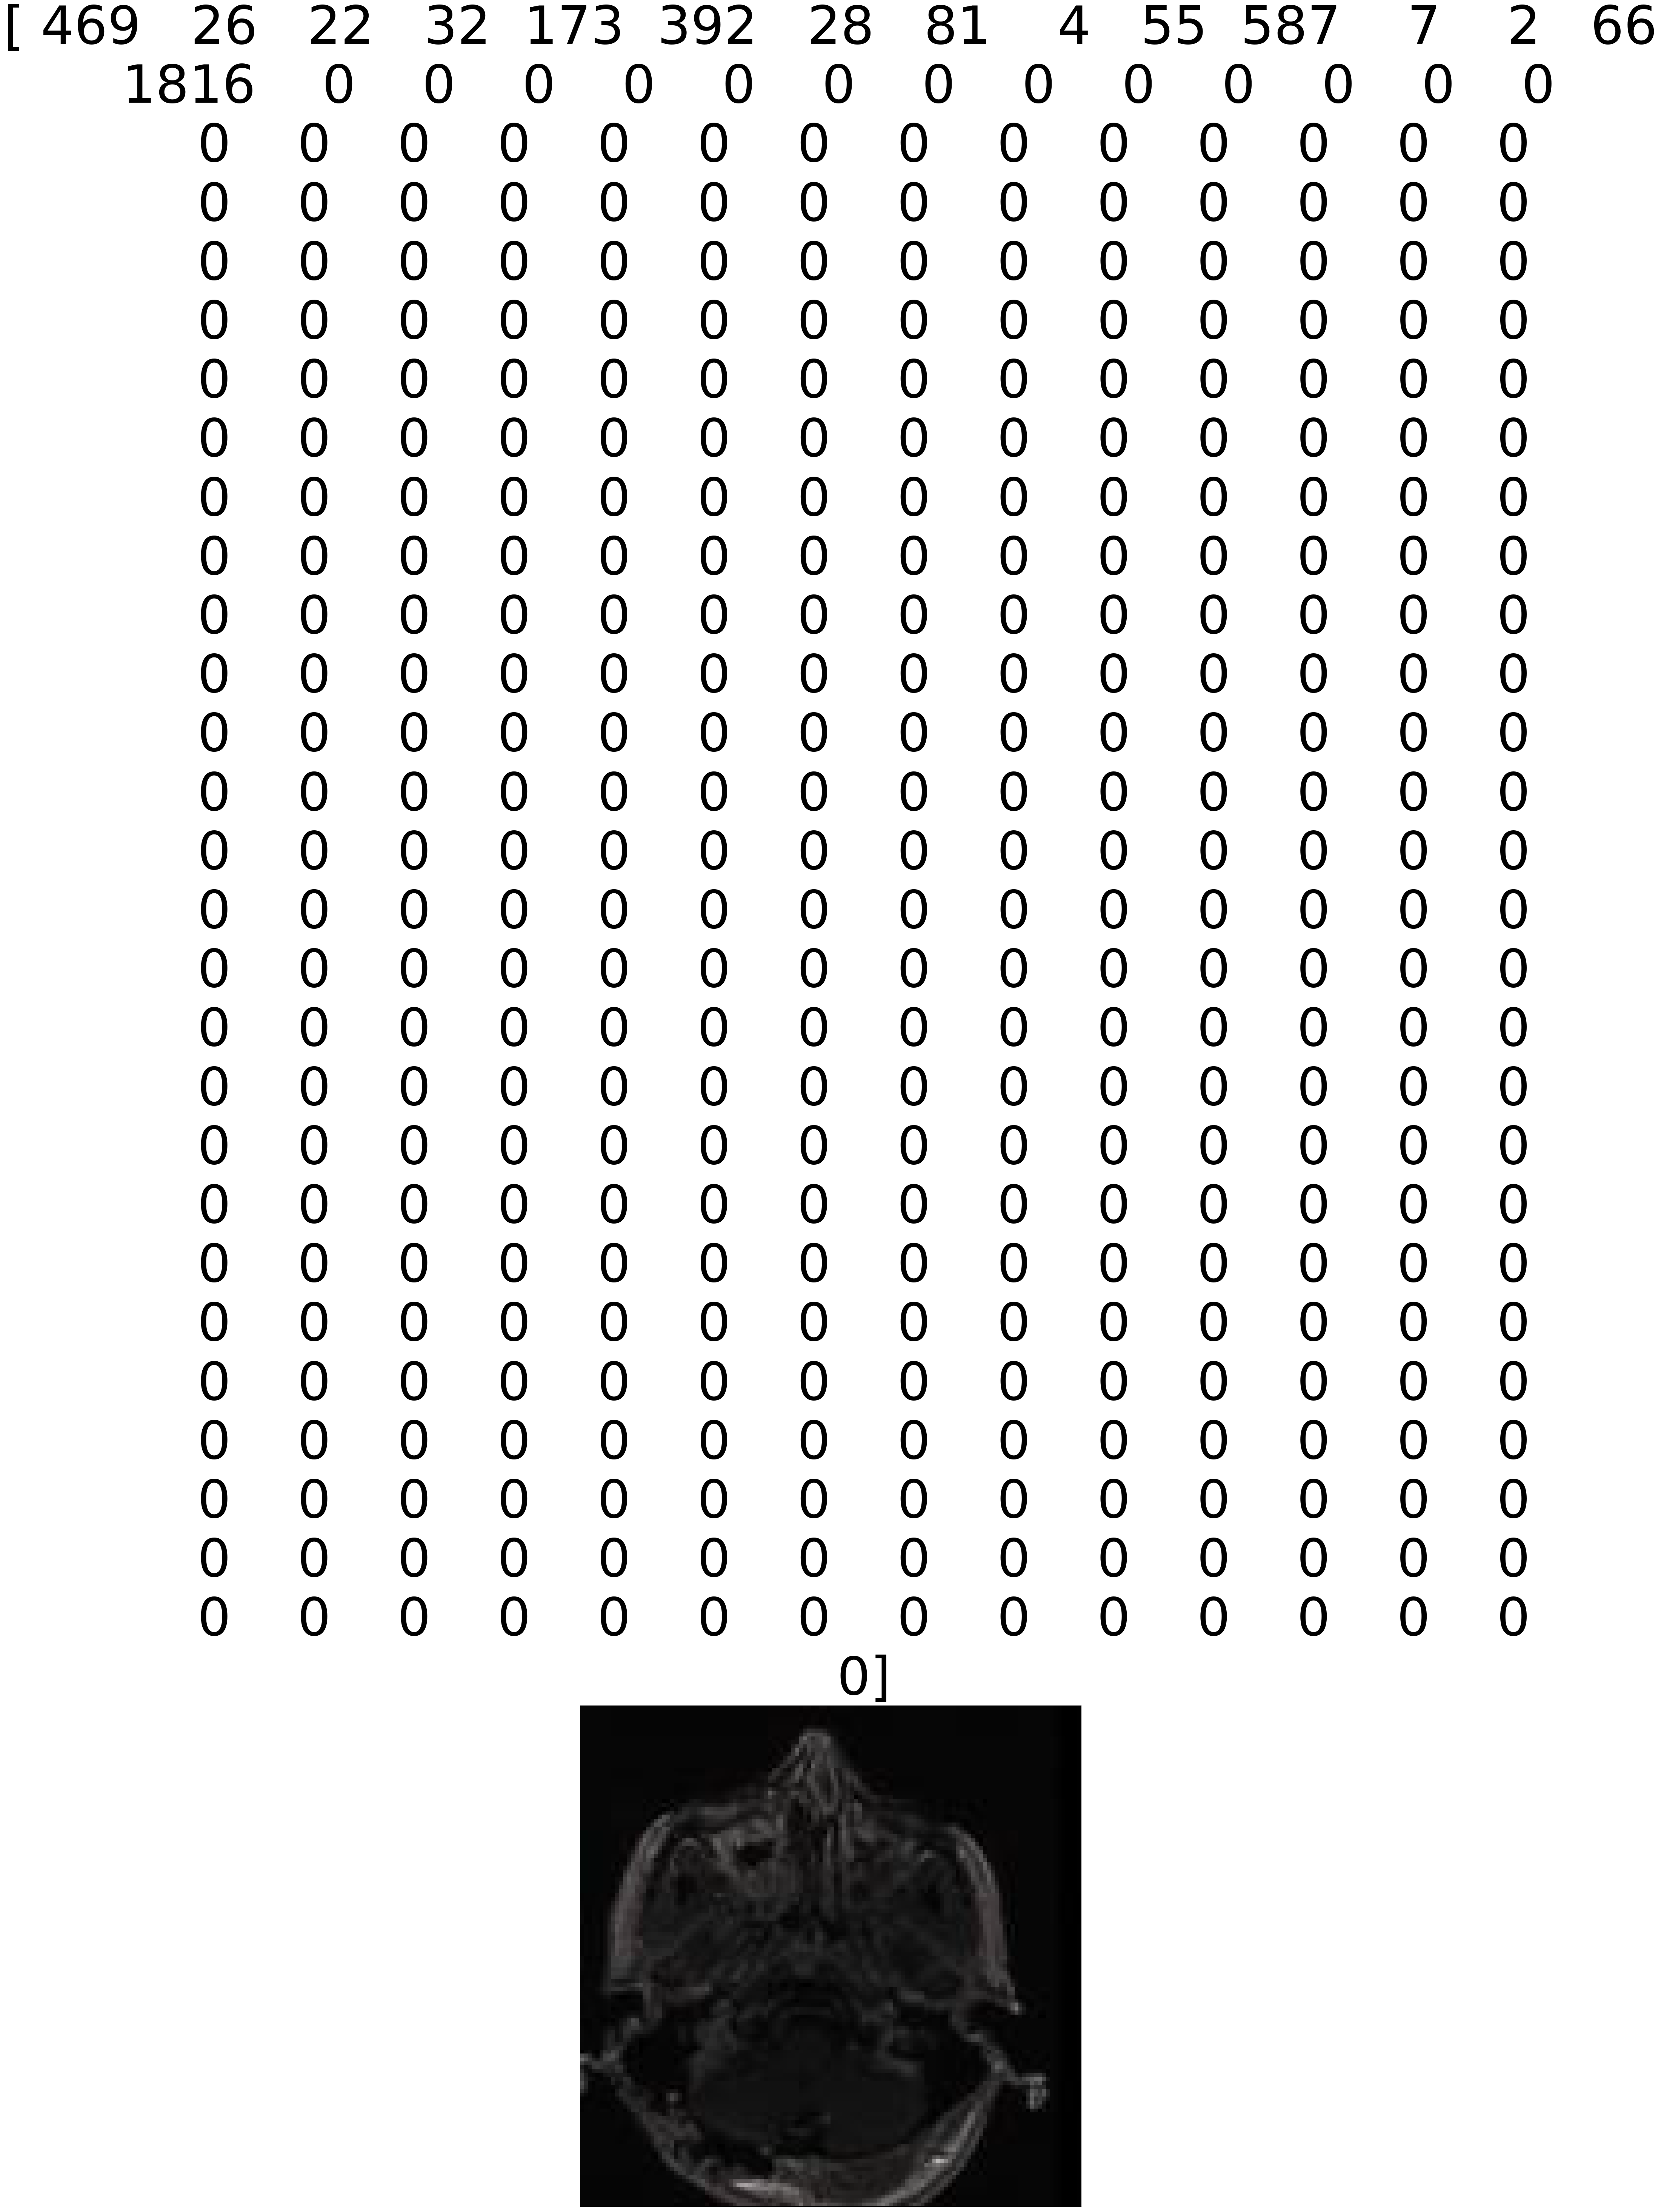

In [10]:
visualize_dataset(ds_train, 5)

In [11]:
def CNN_embedding(input_shape, latent_dim, embed_dim, seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='img_input_layer')
    x = tfkl.ZeroPadding2D((2,2))(input_layer)

    x = tfkl.Conv2D(64, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Flatten()(x)
    x = tfkl.Dense(latent_dim, activation='relu')(x)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)

    # Connect input and output through the Model class
    cnn_encoder = tfk.Model(inputs=input_layer, outputs=x, name='image_encoder')

    # Return the discriminator
    return cnn_encoder

In [12]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

In [13]:
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)
        
    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

In [14]:
def text_embedding(sequence_lenght, vocab_size, num_heads, embed_dim, latent_dim):
    
    input_layer = tfk.Input(shape=(None,), dtype="int64", name="text_inputs")
    x = TokenAndPositionEmbedding(sequence_lenght, vocab_size, embed_dim)(input_layer)
    x = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
    
    text_encoder = tfk.Model(input_layer, x)
    
    return text_encoder

In [15]:
def CLIP_loss(_, logits):
    labels = np.arange(y_pred.shape[0])
    
    loss_img = tfk.losses.categorical_crossentropy(logits, labels)
    loss_txt = tfk.losses.categorical_crossentropy(kb.transpose(logits), labels)
    
    return (loss_img + loss_txt)/2

In [16]:
def build_clip(img_input_shape=(128,128,3),
               txt_input_shape=(None, ), 
               latent_dim=1024, 
               embed_dim=128, 
               seq_lenght=393, 
               vocab_size=35491, 
               num_heads=4,
               temp=0.07):
    
    img_input = tfk.Input(shape=img_input_shape)
    txt_input = tfk.Input(shape=txt_input_shape)
    
    img_embed = CNN_embedding(img_input_shape, latent_dim, embed_dim, seed=42)(img_input)
    txt_embed = text_embedding(seq_lenght, vocab_size, num_heads, embed_dim, latent_dim)(txt_input)
    
    img_norm = tfkl.Lambda(lambda x: kb.l2_normalize(x, axis=1))(img_embed)
    txt_norm = tfkl.Lambda(lambda x: kb.l2_normalize(x, axis=1))(txt_embed)
    
    logits = tfkl.Lambda(lambda x: kb.dot(x[0], kb.transpose(x[1])) * kb.exp(temp))((img_norm, txt_norm))
    
    clip = tfk.Model(inputs=[img_input, txt_input], outputs=logits)
    return clip

In [17]:
model = build_clip()
model.summary()

2023-02-01 15:39:44.251936: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 289.00MiB (rounded to 303038464)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-01 15:39:44.251977: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-02-01 15:39:44.251994: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 21, Chunks in use: 21. 5.2KiB allocated for chunks. 5.2KiB in use in bin. 1.3KiB client-requested in use in bin.
2023-02-01 15:39:44.252004: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 5, Chunks in use: 5. 2.5KiB allocated for chunks. 2.5KiB in use in bin. 2.5KiB client-requested in use in bin.
2023-02-01 15:39:44.252012: I tensorflow/ts

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[73984,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
tfk.utils.plot_model(model)

In [ ]:
model.compile(
    loss = CLIP_loss
    optimizer = tfk.optimizer.Adam(),
    metrics = ['mse', 'mae']
)

In [ ]:
model.fit(
    x = ds_train,
    validation_data=val_ds,
    batch_size = 64,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
    ]
)